In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import random

import matplotlib
import matplotlib.pyplot as plt

path = '../data/Output/'

R[write to console]: Loading required package: BRISC

R[write to console]: Loading required package: RANN

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rdist

R[write to console]: Loading required package: matrixStats

R[write to console]: Loading required package: pbapply

R[write to console]: The ordering of inputs x (covariates) and y (response) in BRISC_estimation has been changed BRISC 1.0.0 onwards.
  Please check the new documentation with ?BRISC_estimation.



R package: BRISC installed


/Users/zhanwentao/opt/anaconda3/envs/NN/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def RMSE(x,y):
    x = x.reshape(-1)
    y = y.reshape(-1)
    n = x.shape[0]
    return(np.sqrt(np.sum(np.square(x-y))/n))

In [3]:
def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]) / 6
def f1(X): return 10 * np.sin(2 * np.pi * X)
    
sigma = 5
phi = 0.3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 1;
funXY = f1

n = 1000
b = 10
nn = 20
batch_size = 50

In [4]:
torch.manual_seed(2025)
X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, b])

random.seed(2024)
X, Y, coord, _ = geospaNN.spatial_order(X, Y, coord, method='max-min')
data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn,
                                                      test_proportion=0.2)

In [5]:
torch.manual_seed(2024)
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
nn_model = geospaNN.nn_train(mlp_nn, lr=0.01, min_delta=0.001)
training_log = nn_model.train(data_train, data_val, data_test, seed = 2024)
theta0 = geospaNN.theta_update(mlp_nn(data_train.x).squeeze() - data_train.y,
                               data_train.pos, neighbor_size=20)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nn, theta=torch.tensor(theta0))
predict_nn = model.predict(data_train, data_test)

Epoch 00061: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00068: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch71
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[3.8977135  0.48003391 0.01919864]


In [6]:
torch.manual_seed(2024)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
model_nngls = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = geospaNN.nngls_train(model_nngls, lr=0.1, min_delta=0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init=20, Update_step=10, seed = 2024)
theta_hat = geospaNN.theta_update(mlp_nngls(data_train.x).squeeze() - data_train.y,
                                  data_train.pos, neighbor_size = 20)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta_hat))
predict_nngls = model.predict(data_train, data_test)

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[3.74956068 0.58783613 0.05867977]
to
[3.74956068 0.58783613 0.05867977]
Epoch 00023: reducing learning rate of group 0 to 5.0000e-02.
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covar

In [7]:
print(theta_hat)
print(theta0)

[4.26710204 0.41945289 0.0132123 ]
[3.8977135  0.48003391 0.01919864]


In [8]:
data_add_train = geospaNN.make_graph(torch.concat([data_train.x, data_train.pos], axis = 1), 
                                     data_train.y, data_train.pos, nn)
data_add_val = geospaNN.make_graph(torch.concat([data_val.x, data_val.pos], axis = 1), 
                                   data_val.y, data_val.pos, nn)
data_add_test = geospaNN.make_graph(torch.concat([data_test.x, data_test.pos], axis = 1), 
                                    data_test.y, data_test.pos, nn)

In [9]:
torch.manual_seed(2024)
np.random.seed(0)
data_add_train, data_add_val, data_add_test = geospaNN.split_data(torch.concat([X, coord], axis = 1), Y, coord, neighbor_size=nn,
                                                                  test_proportion=0.2)

In [10]:
torch.manual_seed(2025)
mlp_nn_add = torch.nn.Sequential(
    torch.nn.Linear(p+2, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
nn_add_model = geospaNN.nn_train(mlp_nn_add, lr=0.01, min_delta=0.001)
training_log = nn_add_model.train(data_add_train, data_add_val, data_add_test, seed = 2024)
predict_nn_add = mlp_nn_add(data_add_test.x).detach().numpy().reshape(-1)

Epoch 00087: reducing learning rate of group 0 to 5.0000e-03.


In [11]:
coord_np = coord.detach().numpy()
num_basis = [2 ** 2, 4 ** 2, 6 ** 2]
knots_1d = [np.linspace(0, 1, int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi_temp = np.zeros((n, sum(num_basis)))
for res in range(len(num_basis)):
    theta_temp = 1 / np.sqrt(num_basis[res]) * 2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res], knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(), knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(coord_np / b - knots[i, :], axis=1) / theta_temp
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_temp[j, i + K] = (1 - d[j]) ** 6 * (35 * d[j] ** 2 + 18 * d[j] + 3) / 3
            else:
                phi_temp[j, i + K] = 0
    K = K + num_basis[res]

torch.manual_seed(2024)
np.random.seed(0)
data_DK_train, data_DK_val, data_DK_test = geospaNN.split_data(torch.concat([X, torch.from_numpy(phi_temp)], axis = 1).float(), 
                                                               Y, coord, neighbor_size=nn, test_proportion=0.2)

In [12]:
torch.manual_seed(2024)
mlp_nn_DK = torch.nn.Sequential(
    torch.nn.Linear(p+K, 50),
    torch.nn.ReLU(), 
    torch.nn.Linear(50, 20), 
    torch.nn.ReLU(), 
    torch.nn.Linear(20, 1)) 
nn_DK_model = geospaNN.nn_train(mlp_nn_DK, lr=0.01, min_delta=0.001) 
training_log = nn_DK_model.train(data_DK_train, data_DK_val, data_DK_test, seed = 2024) 
predict_DK = mlp_nn_DK(data_DK_test.x).detach().numpy().reshape(-1)

Epoch 00054: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00061: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch64


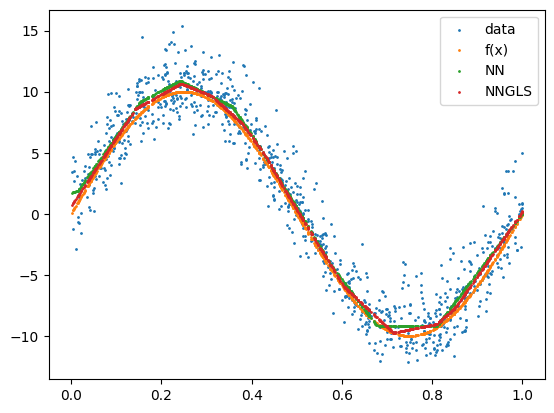

In [13]:
plt.clf()
plt.scatter(X.detach().numpy(), Y.detach().numpy(), s=1, label='data')
plt.scatter(X.detach().numpy(), funXY(X.detach().numpy()), s=1, label='f(x)')
plt.scatter(X.detach().numpy(), mlp_nn(X).detach().numpy(), s=1, label='NN')
plt.scatter(X.detach().numpy(), mlp_nngls(X).detach().numpy(), s=1, label='NNGLS')
plt.legend()
plt.show()

RMSE nn-estimate:  2.98
RMSE nngls:  0.45
RMSE nn+kriging: 0.52
RMSE nn-add-coordinates: 2.84
RMSE nn-Deepkrig: 1.59


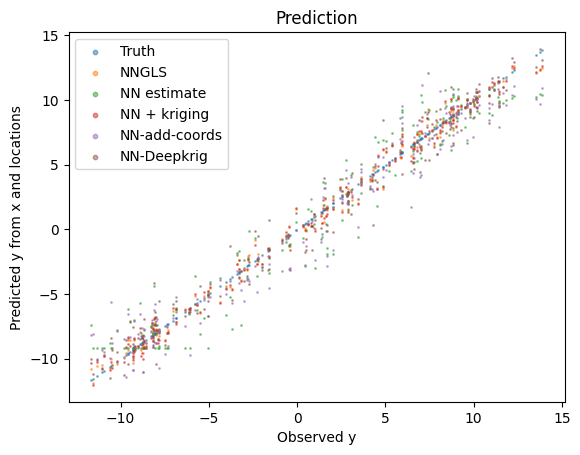

In [14]:
estimate_nn = mlp_nn(data_test.x).detach().numpy().reshape(-1)
plt.clf()
plt.scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s=1, alpha = 0.5, label='Truth')
plt.scatter(data_test.y.detach().numpy(), predict_nngls, s=1, alpha = 0.5, label='NNGLS')
plt.scatter(data_test.y.detach().numpy(), estimate_nn, s=1, alpha = 0.5, label='NN estimate')
plt.scatter(data_test.y.detach().numpy(), predict_nn, s=1, alpha = 0.5, label='NN + kriging')
plt.scatter(data_test.y.detach().numpy(), predict_nn_add, s=1, alpha = 0.5, label='NN-add-coords')
plt.scatter(data_test.y.detach().numpy(), predict_DK, s=1, alpha = 0.5, label='NN-Deepkrig')
#plt.scatter(data_test.y.detach().numpy(), predict3, s=1, alpha = 0.5, label='NNGLS nugget 97%')
lgnd = plt.legend(fontsize=10)
plt.xlabel('Observed y', fontsize=10)
plt.ylabel('Predicted y from x and locations', fontsize=10)
plt.title('Prediction')

for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
plt.savefig(path + 'Prediction_block5.png')

print(f"RMSE nn-estimate:  {torch.mean((data_test.y - estimate_nn)**2):.2f}")
print(f"RMSE nngls:  {torch.mean((data_test.y - predict_nngls)**2):.2f}")
print(f"RMSE nn+kriging: {torch.mean((data_test.y - predict_nn)**2):.2f}")
print(f"RMSE nn-add-coordinates: {torch.mean((data_test.y - predict_nn_add)**2):.2f}")
print(f"RMSE nn-Deepkrig: {torch.mean((data_test.y - predict_DK)**2):.2f}")

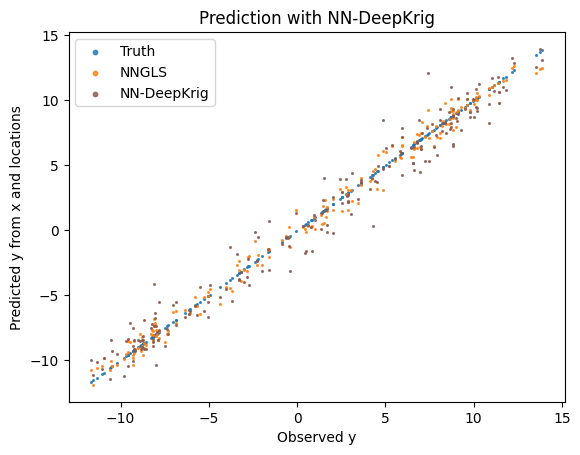

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = ["Truth", "NNGLS", "NN estimate", "NN + kriging", "NN-add-coords", "NN-DeepKrig"]
data = [data_test.y.detach().numpy(), predict_nngls, estimate_nn, predict_nn,  predict_nn_add, predict_DK]

for i, label in enumerate(labels):
    if i <= 1:
        continue
    plt.clf()
    plt.scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s=1.5, alpha = 0.8, label='Truth')
    plt.scatter(data_test.y.detach().numpy(), predict_nngls, s=1.5, alpha = 0.8, label='NNGLS')
    plt.scatter(data_test.y.detach().numpy(), data[i], s=1.5, alpha = 0.8, label=label, color = colors[i])
    #plt.scatter(data_test.y.detach().numpy(), predict3, s=1, alpha = 0.5, label='NNGLS nugget 97%')
    lgnd = plt.legend(fontsize=10)
    plt.xlabel('Observed y', fontsize=10)
    plt.ylabel('Predicted y from x and locations', fontsize=10)
    plt.title('Prediction with ' + label)
    
    for handle in lgnd.legend_handles:
        handle.set_sizes([10.0])
    #plt.show()
    plt.savefig(path + 'Prediction_[5 03 01]_' + label + '.png')

In [16]:
MSE_nngls = []
MSE_nn = []
MSE_nnkrig = []
MSE_nnadd = []
MSE_nnDK = []
n_vec = [1000, 2000, 5000, 10000]

for n in n_vec:
    b = 10
    torch.manual_seed(2025)
    X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, b])

    random.seed(2024)
    X, Y, coord, _ = geospaNN.spatial_order(X, Y, coord, method='max-min')
    data = geospaNN.make_graph(X, Y, coord, nn)
    
    torch.manual_seed(2024)
    np.random.seed(0)
    data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn,
                                                          test_proportion=0.2)
    torch.manual_seed(2024)
    mlp_nn = torch.nn.Sequential(
        torch.nn.Linear(p, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1)
    )
    nn_model = geospaNN.nn_train(mlp_nn, lr=0.01, min_delta=0.001)
    training_log = nn_model.train(data_train, data_val, data_test, seed = 2024)
    theta0 = geospaNN.theta_update(mlp_nn(data_train.x).squeeze() - data_train.y,
                                   data_train.pos, neighbor_size=20)
    model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nn, theta=torch.tensor(theta0))
    predict_nn = model.predict(data_train, data_test)
    estimate_nn = mlp_nn(data_test.x).detach().numpy().reshape(-1)
    
    torch.manual_seed(2024)
    mlp_nngls = torch.nn.Sequential(
        torch.nn.Linear(p, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1)
    )
    model_nngls = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
    nngls_model = geospaNN.nngls_train(model_nngls, lr=0.1, min_delta=0.001)
    training_log = nngls_model.train(data_train, data_val, data_test,
                                     Update_init=20, Update_step=10, seed = 2024)
    theta_hat = geospaNN.theta_update(mlp_nngls(data_train.x).squeeze() - data_train.y,
                                      data_train.pos, neighbor_size = 20)
    model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta_hat))
    predict_nngls = model.predict(data_train, data_test)

    torch.manual_seed(2024)
    np.random.seed(0)
    data_add_train, data_add_val, data_add_test = geospaNN.split_data(torch.concat([X, coord], axis = 1), Y, coord, neighbor_size=nn,
                                                                      test_proportion=0.2)
    mlp_nn_add = torch.nn.Sequential(
        torch.nn.Linear(p+2, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1)
    )
    nn_add_model = geospaNN.nn_train(mlp_nn_add, lr=0.01, min_delta=0.001)
    training_log = nn_add_model.train(data_add_train, data_add_val, data_add_test, seed = 2024)
    predict_nn_add = mlp_nn_add(data_add_test.x).detach().numpy().reshape(-1)

    coord_np = coord.detach().numpy()
    num_basis = [2 ** 2, 4 ** 2, 6 ** 2]
    knots_1d = [np.linspace(0, 1, int(np.sqrt(i))) for i in num_basis]
    ##Wendland kernel
    K = 0
    phi_temp = np.zeros((n, sum(num_basis)))
    for res in range(len(num_basis)):
        theta_temp = 1 / np.sqrt(num_basis[res]) * 2.5
        knots_s1, knots_s2 = np.meshgrid(knots_1d[res], knots_1d[res])
        knots = np.column_stack((knots_s1.flatten(), knots_s2.flatten()))
        for i in range(num_basis[res]):
            d = np.linalg.norm(coord_np / b - knots[i, :], axis=1) / theta_temp
            for j in range(len(d)):
                if d[j] >= 0 and d[j] <= 1:
                    phi_temp[j, i + K] = (1 - d[j]) ** 6 * (35 * d[j] ** 2 + 18 * d[j] + 3) / 3
                else:
                    phi_temp[j, i + K] = 0
        K = K + num_basis[res]

    torch.manual_seed(2024)
    np.random.seed(0)
    data_DK_train, data_DK_val, data_DK_test = geospaNN.split_data(torch.concat([X, torch.from_numpy(phi_temp)], axis = 1).float(), 
                                                                   Y, coord, neighbor_size=nn, test_proportion=0.2)
    mlp_nn_DK = torch.nn.Sequential(
        torch.nn.Linear(p+K, 50),
        torch.nn.ReLU(), 
        torch.nn.Linear(50, 20), 
        torch.nn.ReLU(), 
        torch.nn.Linear(20, 1)) 
    nn_DK_model = geospaNN.nn_train(mlp_nn_DK, lr=0.05, min_delta=0.001) 
    training_log = nn_DK_model.train(data_DK_train, data_DK_val, data_DK_test, seed = 2024) 
    predict_DK = mlp_nn_DK(data_DK_test.x).detach().numpy().reshape(-1)

    
    MSE_nngls.append(torch.mean((data_test.y - predict_nngls)**2))
    MSE_nn.append(torch.mean((data_test.y - estimate_nn)**2))
    MSE_nnkrig.append(torch.mean((data_test.y - predict_nn)**2))
    MSE_nnadd.append(torch.mean((data_test.y - predict_nn_add)**2))
    MSE_nnDK.append(torch.mean((data_test.y - predict_DK)**2))

Epoch 00061: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00068: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch71
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[3.8977135  0.48003391 0.01919864]
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
------------------------------------

In [17]:
df_MSE = pd.DataFrame(
    {'NN estimate': np.array(MSE_nn), 'NN+kriging': np.array(MSE_nnkrig), 
     'NNGLS': np.array(MSE_nngls), 'NN-add-coords': np.array(MSE_nnadd),
     'NN-DeepKrig': np.array(MSE_nnDK),
     'n': n_vec}
)
df_MSE

,NN estimate,NN+kriging,NNGLS,NN-add-coords,NN-DeepKrig,n
0,2.983742,0.523556,0.454370,3.699407,2.003776,1000
1,2.921750,0.460017,0.453934,3.302231,1.425005,2000
2,3.181067,0.370218,0.507125,2.772930,1.713040,5000
3,2.984987,0.291051,0.293493,3.140883,1.588460,10000


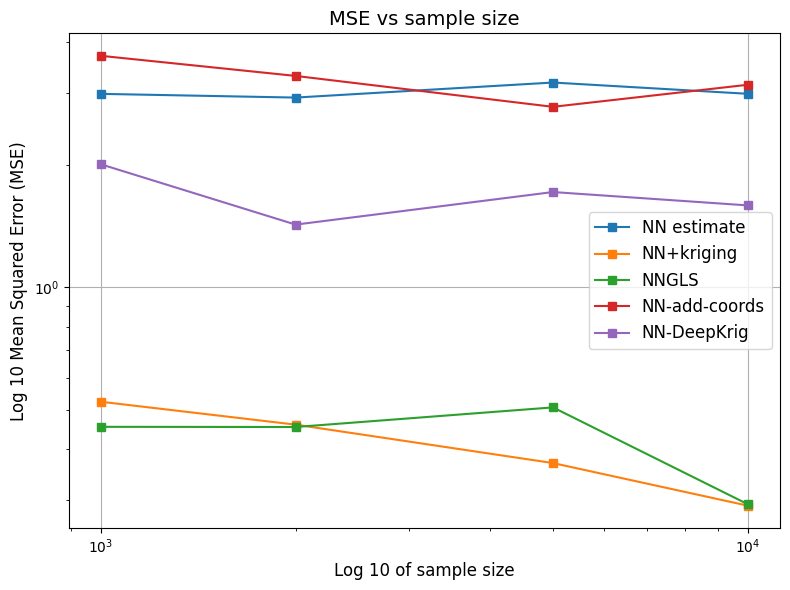

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(df_MSE['n'], df_MSE['NN estimate'], label='NN estimate', linestyle='-', marker='s')
plt.plot(df_MSE['n'], df_MSE['NN+kriging'], label='NN+kriging', linestyle='-', marker='s')
plt.plot(df_MSE['n'], df_MSE['NNGLS'], label='NNGLS', linestyle='-', marker='s')
plt.plot(df_MSE['n'], df_MSE['NN-add-coords'], label='NN-add-coords', linestyle='-', marker='s')
plt.plot(df_MSE['n'], df_MSE['NN-DeepKrig'], label='NN-DeepKrig', linestyle='-', marker='s')

# Add titles and labels
plt.title('MSE vs sample size', fontsize=14)
plt.xlabel('Log 10 of sample size', fontsize=12)
plt.ylabel('Log 10 Mean Squared Error (MSE)', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(path + "MSE_vs_samplesize.png")